In [ ]:
from langgraph.graph import StateGraph, START, END, MessagesState
from typing import TypedDict, Annotated
import operator
from langchain_ollama import ChatOllama
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
import requests
import json
from langchain_core.tools import tool

In [2]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [ ]:
llm = ChatOllama(temperature=0, model="qwen3-vl:2b")

system_prompt = """You are a helpful chatbot. You can help users with their questions.You can also ask questions to clarify the user's intent. You can also provide information to the user."""

def call_llm(state: AgentState):
    messages = state["messages"]
    messages = [SystemMessage(content=system_prompt)] + messages
    message = llm.invoke(messages)
    return {"messages" : [message]}

In [ ]:
def call_llm(state: AgentState):
    messages = state["messages"]
    messages = [SystemMessage(content=system_prompt)] + messages
    message = llm.invoke(messages)
    return {"messages" : [message]}

In [5]:
# Build graph
graph = StateGraph(AgentState)
graph.add_node("llm", call_llm)
graph.add_edge(START, "llm")
graph.add_edge("llm", END)
agent = graph.compile()

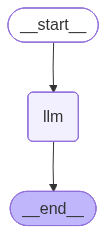

In [6]:
# Visualize the graph
display(Image(agent.get_graph().draw_mermaid_png()))

In [7]:
# Test it
response = agent.invoke({"messages": [HumanMessage(content="What is the capital of France?")]})
print(response["messages"][-1].content)

The capital of France is **Paris**.  

### Key Details:
- **Official Status**: Paris is the seat of the French government, including the President of France, the National Assembly, and the Senate.
- **Historical Significance**: It has been the capital since the Middle Ages (officially recognized by the French Constitution in 1791).
- **Population**: It is the largest city in France and the most populous city in the country.
- **Symbolism**: The city is home to iconic landmarks like the Eiffel Tower, Notre-Dame Cathedral, and the Louvre Museum.

If you're curious about why Paris was chosen as the capital or its role in French history, feel free to ask! 😊


In [ ]:
@tool
def get_weather(latitude: float, longitude: float) -> str:
    """Get current temperature in Fahrenheit and weather code for given coordinates.

    Args:
        latitude: Latitude coordinate
        longitude: Longitude coordinate

    Returns:
        JSON string with temperature_fahrenheit and weather_code (do not include the code in your response, translate it to plain English)
    """
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "current": "temperature_2m,weather_code",
        "temperature_unit": "fahrenheit"
    }

    weather = requests.get(url, params=params).json()["current"]
    temperature = weather["temperature_2m"]
    weather_code = weather["weather_code"]

    result = {
        "temperature_fahrenheit": temperature,
        "weather_code": weather_code
    }

    return json.dumps(result)

In [ ]:
tools = [get_weather]

In [ ]:
model = llm.bind_tools(tools)
tools_map = {tool.name: tool for tool in tools}

def call_llm(state: AgentState):
    messages = state['messages']
    messages = [SystemMessage(content=prompt)] + messages
    message = model.invoke(messages)
    return {'messages': [message]}